Поработаем над датасетом из соревнования [UtkMl](https://www.kaggle.com/competitions/utkmls-twitter-spam-detection-competition/overview) про определение спама в твитах.  

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer # обрабатывает и текстовые признаки и нетекстовые
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn import metrics

from sklearn.metrics import classification_report

from nltk.tokenize import word_tokenize

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('train.csv')
data.drop('Unnamed: 7', axis=1, inplace=True)
data.head()

,Tweet,following,followers,actions,is_retweet,location,Type
0,Good Morning Love @LeeBrown_V,0.0,0.0,0.0,0.0,"Pennsylvania, USA",Quality
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0,61060.0,5001.0,0.0,"South Padre Island, Texas",Spam
2,Haven't been following the news but I understa...,0.0,0.0,NaN,0.0,Will never be broke ever again,Quality
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0,0.0,0.0,0.0,Mundo,Quality
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0,35100.0,NaN,0.0,"Nottingham, England",Quality


Почистим датасет

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14899 entries, 0 to 14898
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tweet       14899 non-null  object 
 1   following   14741 non-null  float64
 2   followers   14882 non-null  float64
 3   actions     11462 non-null  float64
 4   is_retweet  14898 non-null  float64
 5   location    12888 non-null  object 
 6   Type        14899 non-null  object 
dtypes: float64(4), object(3)
memory usage: 814.9+ KB


In [ ]:
data.Type.unique()

array(['Quality', 'Spam', 'South Dakota'], dtype=object)

In [ ]:
data = data[data.Type != "South Dakota"]

In [ ]:
data['Type'] = data['Type'].apply(lambda x: 0 if x == 'Quality' else 1)

In [ ]:
data.drop('location', axis=1, inplace=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
y = data['Type']
X = data.drop('Type', axis=1)

Давайте построим графики.

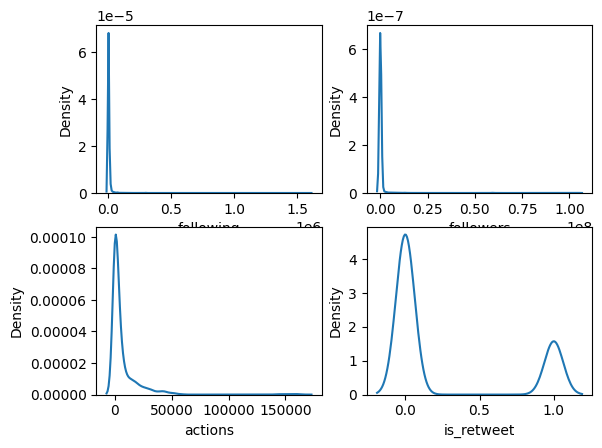

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
for ax, feat in zip(axes.flat, X.select_dtypes(include=np.number).columns):
    sns.kdeplot(X[feat], ax=ax)
plt.show()

Видим, что а) ни один из признаков не имеет нормального распределения б) для небинарных признаков самое частое значение - 0. Скорее всего, наиболее важную информацию несут сами твиты (мы намеренно не будем удалять ссылки и хештеги, потому что они, скорее всего, вообще сделают самый важный вклад).

Теперь нам необходимо обработать наши признаки. Часть из них - текстовые, и их нужно обработать отдельно.

In [ ]:
def feature_engineering(choice_transformer, choice_ngrams):
    # числовые характеристики нормализуем: imputer обрабатывает наны, scaler масштабирует
    numeric_features = ['following', 'followers', 'actions', 'is_retweet']
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
    )

    # текстовые характеристики обрабатываем: либо tf-idf, либо мешок слов
    text_features = 'Tweet'
    if choice_transformer == 'tfidf':
        text_transformer = TfidfVectorizer(ngram_range=choice_ngrams, tokenizer=word_tokenize, stop_words='english')
    else:
        text_transformer = CountVectorizer(ngram_range=choice_ngrams, tokenizer=word_tokenize, stop_words='english')

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("txt", text_transformer, text_features),
        ]
    )
    return preprocessor

Обучим модели.

In [ ]:
test = pd.read_csv('test.csv')
test.drop('Id', axis=1, inplace=True)
test.head()

,Tweet,following,followers,actions,is_retweet,location
0,"Cops shoot blacks almost everyday, and there a...",5509.0,5977.0,8062.0,1,ですpacito
1,"#HAPPYTAEYANGDAY Oppa,happy birthday to you, ...",0.0,0.0,NaN,0,NaN
2,RT @HoneyBadger10: Panthers in the super bowl....,471.0,229.0,747.0,0,"B'klyn, NYC, LA"
3,Sorry my Twitter keeps posting my retweets a m...,0.0,79800.0,48.0,0,NaN
4,Heart attack causes and symptoms are different...,902.0,5797.0,4270.0,0,Chicago


In [ ]:
def modelfit(model):
    model.fit(Xtrain, ytrain)

    ypredtest = model.predict(Xtest)
    ypredtrain = model.predict(Xtrain)

    print(accuracy_score(ytest, ypredtest), accuracy_score(ytrain, ypredtrain))

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

TF-IDF unigrams

In [ ]:
preprocessor = feature_engineering('tfidf', (1, 1))

clfLR = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clfSVC = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", SVC())]
)

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
modelfit(clfLR)
modelfit(clfSVC)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.9268456375838926 0.9579592179239742


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.9355704697986578 0.9652597130150206


TF-IDF bigrams

In [ ]:
preprocessor = feature_engineering('tfidf', (2, 2))

clfLR = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clfSVC = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", SVC())]
)

In [ ]:
modelfit(clfLR)
modelfit(clfSVC)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.8781879194630873 0.9405051606948057


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.8832214765100671 0.9145758160610892


BOW unigrams

In [ ]:
preprocessor = feature_engineering('bow', (1, 1))

clfLR = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clfSVC = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", SVC())]
)

In [ ]:
modelfit(clfLR)
modelfit(clfSVC)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9348993288590604 0.9873290257615172


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.9489932885906041 0.9773432910967526


BOW bigrams

In [ ]:
preprocessor = feature_engineering('bow', (2, 2))

clfLR = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clfSVC = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", SVC())]
)

In [ ]:
modelfit(clfLR)
modelfit(clfSVC)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.9204697986577182 0.9910212301753797


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.9124161073825503 0.976671981203323


BOW Bagging

In [ ]:
preprocessor = feature_engineering('bow', (1, 1))

bagging = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", BaggingClassifier())]
)

In [ ]:
modelfit(bagging)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.9892617449664429 0.9979860703197113


In [ ]:
preprocessor = feature_engineering('bow', (2, 2))

bagging = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", BaggingClassifier())]
)

In [ ]:
modelfit(bagging)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.9922818791946308 0.9989930351598557


Random Forest

In [ ]:
preprocessor = feature_engineering('bow', (2, 2))

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)

modelfit(clf)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.9942953020134229 1.0


Проверка только на твитах (чтобы посмотреть, что влияет сильнее всего)

In [ ]:
vec = CountVectorizer(ngram_range=(3, 3), tokenizer=word_tokenize, stop_words='english')
bow = vec.fit_transform(Xtrain['Tweet'])
clf = DecisionTreeClassifier()
clf.fit(bow, ytrain)
ypredtest = clf.predict(vec.transform(Xtest['Tweet']))
print(classification_report(ypredtest, ytest))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           0       0.95      0.59      0.73      2413
           1       0.34      0.88      0.49       567

    accuracy                           0.65      2980
   macro avg       0.64      0.74      0.61      2980
weighted avg       0.84      0.65      0.68      2980



In [ ]:
list(vec.vocabulary_.items())[:10]

[('citizen , remember', 38495),
 (', remember powers', 11238),
 ('remember powers government', 85950),
 ('powers government spring', 82601),
 ('government spring sovereign', 52539),
 ('spring sovereign !', 92869),
 ('local seo :', 70148),
 ('seo : voice', 90007),
 (': voice online', 24058),
 ('voice online market', 102294)]

Проверим гипотезу о том, что ссылки сильнее всего влияют на определение спама

In [ ]:
tweets = list(data['Tweet'])
nums = []

for num, w in enumerate(tweets):
    if 't.co' in w:
        nums.append(num)

In [ ]:
spamham = list(data['Type'])
needed = []
for i, w in enumerate(spamham):
    if i in nums:
        needed.append(w)

In [ ]:
from collections import Counter

Counter(needed)

Counter({1: 4551, 0: 67})

Оказывается, подавляющее большинство текстов со ссылками определено как спам.

А теперь давайте посмотрим, как можно было ту же задачу решить с помощью эмбеддингов Doc2Vec из gensim.

In [ ]:
!pip install gensim

In [ ]:
from gensim.models import Doc2Vec # возвращает эмбеддинги для текста
import gensim
from gensim.models.doc2vec import TaggedDocument
from sklearn import utils
from tqdm import tqdm

In [ ]:
gensim.__version__

'4.3.2'

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')

def tokenize_text(text):
    '''gensim сам токенизировать не умеет, поэтому нам придется сделать это за него'''
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

train, test = train_test_split(data[['Tweet', 'Type']], test_size=0.3, random_state=42)

# соберем специальный объект класса TaggedDocument, чтобы D2V работал
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Tweet']), tags=[r.Type]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Tweet']), tags=[r.Type]), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Воспользуемся тем, что у большинства современных процессоров больше одного ядра...

In [ ]:
import multiprocessing # Global interpreter lock - ограничивает ядра процессора (сейчас только 1 ядро)
cores = multiprocessing.cpu_count()

In [ ]:
cores # нужно чтобы doc2vec учился быстрее

2

Обучим модельку DBoW (Distributed Bag of Words)

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample=0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 10427/10427 [00:00<00:00, 1142625.94it/s]


In [ ]:
for epoch in range(30): # ЭПОХА - модель не учится на всех данных сразу на датасэте (считает градиенты по датасету). Эпоха - это когда модель обучитлась по всему датасету
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 10427/10427 [00:00<00:00, 1700058.61it/s]


Напишем аналог transform для D2V:

In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

Обучим банальную логистическую регрессию

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(solver='liblinear', n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6572706935123043
Testing F1 score: 0.6569136394927754


С другими алгоритмами можете побаловаться сами.